In [2]:
import numpy as np
import pandas as pd 
x = np.loadtxt("x.txt").reshape(246082, 28, 28)

df = pd.read_csv('y.txt',sep="\r\n")
y = np.array(df)

<ipython-input-2-efccf7c967fd>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('y.txt',sep="\r\n")


In [3]:
print(x.shape, y.shape)

(246082, 28, 28) (246081, 1)


In [4]:
# Создание нейросети: 1. Импорт Библиотек
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # построение графиков
import matplotlib.image as mpimg  #  вывод изображений cv2 формата
import os 
import cv2  # считывание и обработка изображений
import seaborn as sns  # график-гистограмма количества элементов
from keras.utils.np_utils import to_categorical # перевод числа в вектор
from keras.models import Sequential  # конструктор нейросети
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Activation # слои, функции активации, свёртки
from tensorflow.keras.optimizers import RMSprop, Adam  #  оптимизаторы
from keras.preprocessing.image import ImageDataGenerator  #генератор для увеличения обуч набора
from keras.callbacks import ReduceLROnPlateau  # контроль LearningRate
import keras # Базовый класс
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

Num GPUs Available:  1


In [5]:
# делим на тестовый и тренировочный наборы 1 к 20
x_test, y_test = x[::20], y[::20]

x_train= np.array([item for index, item in enumerate(x) if (index) % 20 != 0])
y_train= np.array([item for index, item in enumerate(y.reshape(len(y))) if (index) % 20 != 0])
print(x_train.shape, y_train.shape)


# нормализация
x_train = np.array(x_train)/255
x_test = np.array(x_test)/255

(233777, 28, 28) (233776,)


d:\changeface\miniconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


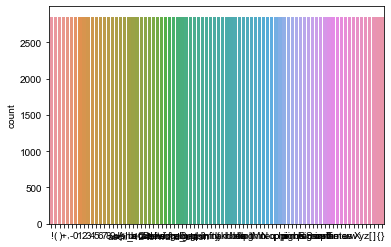

In [6]:
g = sns.countplot(y_train)
sns.set(rc={'figure.figsize':(11.7,8.27)})
#это оказалось большой проблемой в обучении, 
#нужно хоть немного уравнять пропорции иначе сеть
# будет плохо обучаема

In [7]:
from operator import itemgetter
#enum_labels = [[index,item] for index, item in enumerate(sorted(list(set(y.reshape(len(y))))))]
enum_labels = [[0, '!'], [1, '('], [2, ')'], [3, '+'], [4, ','], [5, '-'], [6, '0'], [7, '1'], [8, '2'], [9, '3'], [10, '4'], [11, '5'], [12, '6'], [13, '7'], [14, '8'], [15, '9'], [16, '='], [17, 'A'], [18, 'C'], [19, 'Delta'], [20, 'G'], [21, 'H'], [22, 'M'], [23, 'N'], [24, 'R'], [25, 'S'], [26, 'T'], [27, 'X'], [28, '['], [29, ']'], [30, 'alpha'], [31, 'ascii_124'], [32, 'b'], [33, 'beta'], [34, 'cos'], [35, 'd'], [36, 'div'], [37, 'e'], [38, 'exists'], [39, 'f'], [40, 'forall'], [41, 'forward_slash'], [42, 'gamma'], [43, 'geq'], [44, 'gt'], [45, 'i'], [46, 'in'], [47, 'infty'], [48, 'int'], [49, 'j'], [50, 'k'], [51, 'l'], [52, 'lambda'], [53, 'ldots'], [54, 'leq'], [55, 'lim'], [56, 'log'], [57, 'lt'], [58, 'mu'], [59, 'neq'], [60, 'o'], [61, 'p'], [62, 'phi'], [63, 'pi'], [64, 'pm'], [65, 'prime'], [66, 'q'], [67, 'rightarrow'], [68, 'sigma'], [69, 'sin'], [70, 'sqrt'], [71, 'sum'], [72, 'tan'], [73, 'theta'], [74, 'times'], [75, 'u'], [76, 'v'], [77, 'w'], [78, 'y'], [79, 'z'], [80, '{'], [81, '}']]
def label_to_num(label,enum_labels):
    for i in enum_labels:
        if i[1] == label:
            return i[0]

print(enum_labels) # перевод из подписей в нумерацию для нейросети

[[0, '!'], [1, '('], [2, ')'], [3, '+'], [4, ','], [5, '-'], [6, '0'], [7, '1'], [8, '2'], [9, '3'], [10, '4'], [11, '5'], [12, '6'], [13, '7'], [14, '8'], [15, '9'], [16, '='], [17, 'A'], [18, 'C'], [19, 'Delta'], [20, 'G'], [21, 'H'], [22, 'M'], [23, 'N'], [24, 'R'], [25, 'S'], [26, 'T'], [27, 'X'], [28, '['], [29, ']'], [30, 'alpha'], [31, 'ascii_124'], [32, 'b'], [33, 'beta'], [34, 'cos'], [35, 'd'], [36, 'div'], [37, 'e'], [38, 'exists'], [39, 'f'], [40, 'forall'], [41, 'forward_slash'], [42, 'gamma'], [43, 'geq'], [44, 'gt'], [45, 'i'], [46, 'in'], [47, 'infty'], [48, 'int'], [49, 'j'], [50, 'k'], [51, 'l'], [52, 'lambda'], [53, 'ldots'], [54, 'leq'], [55, 'lim'], [56, 'log'], [57, 'lt'], [58, 'mu'], [59, 'neq'], [60, 'o'], [61, 'p'], [62, 'phi'], [63, 'pi'], [64, 'pm'], [65, 'prime'], [66, 'q'], [67, 'rightarrow'], [68, 'sigma'], [69, 'sin'], [70, 'sqrt'], [71, 'sum'], [72, 'tan'], [73, 'theta'], [74, 'times'], [75, 'u'], [76, 'v'], [77, 'w'], [78, 'y'], [79, 'z'], [80, '{'], [8

In [8]:
#сопоставляем значению номер выхода в нейросети
y_train = [label_to_num(label,enum_labels) for label in np.array(y_train).reshape(len(y_train))]
y_test = [label_to_num(label,enum_labels) for label in np.array(y_test).reshape(len(y_test))]
# перевод в вектор [0....0,1,0...]
y_train = to_categorical(y_train, num_classes = len(enum_labels))
y_test = to_categorical(y_test, num_classes = len(enum_labels))

In [9]:
# 1 вариант структуры нейросети 
# input->[conv->activ->pool->]*3->flat->fc1->fc2->fc3->out
#optimizer Adam
def math_symbol_and_digits_recognition(input_shape=(28, 28, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(720, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(504, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(82, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model = math_symbol_and_digits_recognition(input_shape=(28, 28, 1))
model.summary()


def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('Math_CNN_cuda.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]

aug = ImageDataGenerator(zoom_range=0.1,
#                          rotation_range=5,
                         width_shift_range=0.05,
                         height_shift_range=0.05)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 28, 28, 32)        320       
                                                                 
 act1 (Activation)           (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 32)        9248      
                                                                 
 act2 (Activation)           (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                    

In [ ]:
#тренировка модели

#model = keras.models.load_model('Math_CNN_cuda.h5')

if len(x_train)>len(y_train):
    x_train = x_train[:-1]
    
hist = model.fit(aug.flow(x_train.reshape(len(x_train),28,28,1), y_train, batch_size=10,shuffle=True),
                shuffle=True,
                batch_size=10,
                epochs=1,
                validation_data=(x_test.reshape(len(x_test),28,28,1), y_test))

model.save('Math_CNN_cuda.h5')

In [ ]:
#предсказываем тестовый набор
predictions = model.predict(x_test)

for i in range(19):
    result = np.argmax(predictions[i*500])
    print(enum_labels[result][1])

    plt.figure()
    plt.imshow(x_test[i*500])
    plt.colorbar()
    plt.grid(False)

In [2]:
# Извлекаем символы с изображения и переводим в матрицу
def letters_extract(image_file: str, out_size=28):
    img = cv2.imread(image_file)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_erode = cv2.erode(thresh, np.ones((3, 3), np.uint8), iterations=2)#1it

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # plt.imshow(img)
    output = img.copy()

    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        # print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        # hierarchy[i][0]: the index of the next contour of the same level
        # hierarchy[i][1]: the index of the previous contour of the same level
        # hierarchy[i][2]: the index of the first child
        # hierarchy[i][3]: the index of the parent
        if hierarchy[0][idx][3] == 0:
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            letter_crop = gray[y:y + h, x:x + w]
            # print(letter_crop.shape)

            # Resize letter canvas to square
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                # Увеличиваем изображение всерху и снизу
                # ------
                # ======
                # ------
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = letter_crop
            elif w < h:
                # увеличиваем с боков
                # --||--
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = letter_crop
            else:
                letter_square = letter_crop

            # Resize letter to 28x28 and add letter and its X-coordinate
            letters.append((x, w, cv2.resize(letter_square, (out_size, out_size), interpolation=cv2.INTER_AREA)))

    # Sort array in place by X-coordinate
    letters.sort(key=lambda x: x[0], reverse=False)

    #cv2.imshow('image',img)
    # cv2_imshow(thresh)
    # cv2_imshow(img_erode)
    #cv2.imshow('image',output)
    #cv2.imshow('image',letters[0][2])
    # cv2_imshow(letters[1][2])
    # cv2_imshow(letters[2][2])
    # cv2_imshow(letters[3][2])
    # cv2_imshow(letters[4][2])

    # cv2_imshow(letters[5][2])
    # cv2_imshow(letters[6][2])
    # cv2_imshow(letters[7][2])
    # cv2_imshow(letters[8][2])
    #cv2_imshow(letters[9][2])
    #cv2.waitKey(0)
    
    
    #by matplot lib
    
    # plt.imshow(img)
    # plt.show()
    
    plt.imshow(output)
    # plt.show()
    
    # plt.imshow(thresh)
    # plt.show()
    
    # plt.imshow(img_erode)
    # plt.show()
    # for i in range(len(letters)):
    #     plt.imshow(letters[i][2])
    #     plt.show()
 
    return letters


def emnist_predict_img(model, img,enum_labels):
    # img = cv2.imread(img)
    # img = cv2.resize(img,(28,28))
    img = np.array(img)/255

    img_arr = img.reshape(-1,28,28,1)

    predict = model.predict(img_arr)
    result = np.argmax(predict)
    return enum_labels[result][1]

sin
log
=
gamma
X
sum
-
times
6
infty
sum
1
2
d
3
8
f
leq
forward_slash
cos
)


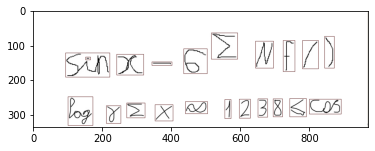

In [6]:
#считываем с картинки
for letter in letters_extract("math5.jpg"):
    print(emnist_predict_img(model,letter[2],enum_labels))

In [3]:
model = keras.models.load_model('Math_CNN_1_structure.h5')

In [1]:
import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

device_name = "gpu"
shape = (10000, 10000)
if device_name == "gpu":
    device_name = "/gpu:0"
else:
    device_name = "/cpu:0"

with tf.device(device_name):
    random_matrix = tf.random_uniform(shape=shape, minval=0, maxval=1)
    dot_operation = tf.matmul(random_matrix, tf.transpose(random_matrix))
    sum_operation = tf.reduce_sum(dot_operation)

startTime = datetime.now()
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
        result = session.run(sum_operation)
        print(result)

### Print the shape, device name and timing
print("\n" * 3)
print("Shape:", shape, "Device:", device_name)
print("Time taken:", datetime.now() - startTime)
print("\n" * 3)

AttributeError: module 'tensorflow' has no attribute 'random_uniform'

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1
